In [ ]:
# See E. Peterfreund, O. Lindenbaum, F. Dietrich, T. Bertalan, M. Gavish, I.G. Kevrekidis and R.R. Coifman,
# "LOCA: LOcal Conformal Autoencoder for standardized data coordinates",
# https://www.pnas.org/doi/full/10.1073/pnas.2014627117
#
#
# -----------------------------------------------------------------------------
# Author: Tom Bertalan, Erez Peterfreund , Ofir Lindenbaum
#                       erezpeter@gmail.com  , ofir.lindenbaum@yale.edu , 2020
# 
# This program is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later
# version.
#
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License along with
# this program.  If not, see <http://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------

In [3]:
# import necessary packages 

import scipy

import numpy as np
import matplotlib.pyplot as plt
from utils import *
from Loca import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2

# Preprocess image- find all the points that are within the building

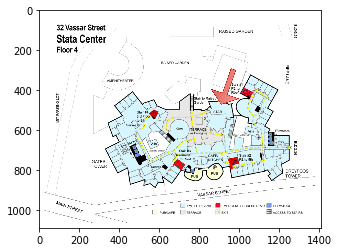

In [4]:
plt.figure()
image = plt.imread('stata_fourth_floor.png')
plt.imshow(image)


In [5]:
image = image[..., :3]

# Take a dropper color.
color_pick_location = (490,500)
crop = [slice(300, 900), slice(300, 1300)]



bluecolor = image[color_pick_location[0], color_pick_location[1]]
cropped = image[crop[0], crop[1]]

# Look for places with color like our dropper color.
blue_places = np.linalg.norm(cropped - bluecolor, axis=2) < .05
raw_mask = mask = blue_places.astype(bool).astype('uint8') * 255

# Do some morphological filtering (fill in some holes and smooth some speckles).
kernelwidth = 3
filtering_iterations = 4
kernel = np.ones((kernelwidth, kernelwidth), np.uint8)

dilate = lambda im, it=filtering_iterations: cv2.dilate(im, kernel, iterations=it)
erode = lambda im, it=filtering_iterations: cv2.erode(im, kernel, iterations=it)

mask = dilate(mask)
mask = erode(mask)

x_interior = np.argwhere(mask)
x_interior= x_interior[np.random.permutation(x_interior.shape[0]),:]


# Extract just the edges also.
edge = np.logical_and(dilate(mask, 1),  np.logical_not(mask))
x_edges = np.argwhere(edge)



# Define the training set as a subset of the interior point, generate bursts and apply the non linear transformation

In [6]:
# Relationship between sensor array and (co)variance of the sensor locations.
pred_var = lambda radius, count : radius**2  * (   count / (count - 1) / 2 )


hotspot_locations = np.array([(250, 200),
            (180, 300),
            (100, 180),
            (125, 395),
            (200, 500),
            (380, 500),
            (400, 400),
            (400, 250),
            (600, 450),
            (550, 200),
            (790, 390),
            (800, 500),
            (850, 300),
            (800, 100),
            (910, 500),
            (900, 340),
            (240, 760)])


def non_linear_function(x):
    hotspot_locations = np.array([(250, 200),
            (180, 300),
            (100, 180),
            (125, 395),
            (200, 500),
            (380, 500),
            (400, 400),
            (400, 250),
            (600, 450),
            (550, 200),
            (790, 390),
            (800, 500),
            (850, 300),
            (800, 100),
            (910, 500),
            (900, 340),
            (760, 240)])
    
    hotspot_locations = hotspot_locations[np.random.permutation(hotspot_locations.shape[0]),:]
                                          
    
    dist_points_hotspots= scipy.spatial.distance.cdist(x.reshape((-1,2)),hotspot_locations ).reshape(x.shape[:-1]+(hotspot_locations.shape[0],))
    return np.exp(-(dist_points_hotspots/600)**2)

def generate_burst(x,cloud_size,sensor_array_radius=0.5):
    cloud_sizes=6
    
    stencil = [(sensor_array_radius * np.cos(theta), sensor_array_radius * np.sin(theta))
                for theta in np.linspace(0, 2*np.pi, cloud_size, endpoint=False)]
    return np.array([
                [(x+dx, y+dy) for (dx, dy) in stencil]
                for (x, y) in x ])

sensor_array_radius=0.5

N= 4000
M = 6
cloud_std= np.sqrt(pred_var(sensor_array_radius,M))

x= x_interior[:N,:]
additionalDataX =   generate_burst(x,M,sensor_array_radius)             


y= non_linear_function(x)
additionalDataY = non_linear_function(additionalDataX)

y_edges= non_linear_function(x_edges)


In [7]:
# Divide into train and validation
N=additionalDataY.shape[0]

indexes = np.random.permutation(N)
indexes_train, indexes_val = indexes[:N*9//10], indexes[N*9//10:]

data_train = additionalDataY[indexes_train,:,:]
data_val = additionalDataY[indexes_val,:,:]

In [8]:
amount_epochs = 20000

params = {}
params['clouds_var']= cloud_std**2

params['activation_enc']='l_relu' # The activation function defined in the encoder
#Options: 'relu'- Relu,   'l_relu'- Leaky Relu,    'sigmoid'-sigmoid,   'tanh'- tanh, 'none'- none
params['activation_dec']='tanh' # The activation function defined in the decoder

params['encoder_layers']=[17,200,200,2,2] # The amount of neurons in each layer of the encoder 
params['decoder_layers']=[2,200,200,17,17] # The amount of neurons in each layer of the decoder 

model = Loca(**params) 


In [ ]:
batch_size=200
lrs= [1e-3,3e-4,1e-4]


model = Loca(**params) 

for lr in lrs:
    model.train( data_train,amount_epochs,lr=lr, batch_size=batch_size, data_val=data_val, evaluate_every=100,verbose=True)

Epoch: 0100 Train : white= 1.01767 rec=0.61333      Val: : white= 1.01652 rec=0.59630
99
Epoch: 0200 Train : white= 1.05326 rec=0.18513      Val: : white= 1.04916 rec=0.18744
199
Epoch: 0300 Train : white= 1.04197 rec=0.17445      Val: : white= 1.03755 rec=0.18108
299
Epoch: 0400 Train : white= 1.08255 rec=0.14172      Val: : white= 1.09630 rec=0.14473
Epoch: 0500 Train : white= 1.10572 rec=0.07635      Val: : white= 1.10820 rec=0.07430
499
Epoch: 0600 Train : white= 1.04551 rec=0.03142      Val: : white= 1.04238 rec=0.02983
599
Epoch: 0700 Train : white= 1.06814 rec=0.03693      Val: : white= 1.02589 rec=0.03789
699
Epoch: 0800 Train : white= 1.02416 rec=0.01671      Val: : white= 1.02789 rec=0.01589
799
Epoch: 0900 Train : white= 1.02788 rec=0.02934      Val: : white= 1.03883 rec=0.02793
Epoch: 1000 Train : white= 1.03210 rec=0.04949      Val: : white= 1.03576 rec=0.04868
Epoch: 1100 Train : white= 1.01923 rec=0.03469      Val: : white= 1.01924 rec=0.03521
Epoch: 1200 Train : white= 

Epoch: 9600 Train : white= 0.24874 rec=0.01667      Val: : white= 0.24215 rec=0.01780
Epoch: 9700 Train : white= 0.26987 rec=0.00379      Val: : white= 0.27522 rec=0.00370
Epoch: 9800 Train : white= 0.16128 rec=0.00348      Val: : white= 0.15389 rec=0.00359
Epoch: 9900 Train : white= 0.11331 rec=0.00076      Val: : white= 0.12633 rec=0.00073
Epoch: 10000 Train : white= 0.10227 rec=0.00098      Val: : white= 0.09492 rec=0.00093
Epoch: 10100 Train : white= 0.08381 rec=0.00167      Val: : white= 0.08072 rec=0.00169
Epoch: 10200 Train : white= 0.18365 rec=0.03567      Val: : white= 0.19099 rec=0.03689
Epoch: 10300 Train : white= 0.10246 rec=0.00262      Val: : white= 0.09657 rec=0.00241
Epoch: 10400 Train : white= 0.04388 rec=0.00148      Val: : white= 0.04303 rec=0.00139
10399
Epoch: 10500 Train : white= 0.06204 rec=0.00052      Val: : white= 0.06872 rec=0.00050
Epoch: 10600 Train : white= 0.06244 rec=0.00040      Val: : white= 0.05704 rec=0.00039
Epoch: 10700 Train : white= 0.08331 rec=0

In [ ]:

embedding, _ = model.test(additionalDataY)


In [ ]:
R,bias, _ = calibrate_data_b(np.mean(additionalDataX,axis=1), np.mean(embedding,axis=1),scaling=True)
calibrated_embedding = np.matmul(embedding,R)+bias 




embedding_edges,_ = model.test(y_edges)
calibrated_embedding_edges= np.matmul(embedding_edges,R)+bias 
                
    
plt.figure(figsize=(20,12))
plt.scatter(calibrated_embedding[:,0,1],-calibrated_embedding[:,0,0], c='red',label='Original locations',s=10)
plt.scatter(additionalDataX[:,0,1],-additionalDataX[:,0,0],label='Calibrated LOCA embedding of the locations',s=10)

plt.scatter(x_edges[1::2,1],-x_edges[1::2,0],s=10,c='black', label='True floor plan edges')
plt.scatter(calibrated_embedding_edges[::2,1],-calibrated_embedding_edges[::2,0],s=10,c='green',label='Calibrated LOCA embedding of the floor plan')

plt.scatter(hotspot_locations[:,1],-hotspot_locations[:,0],marker='+',s=500, c='black',linewidth=5, label='Access point locations')


plt.xlabel(r'$\widetilde{\rho}[1]$',fontsize=35)
plt.ylabel(r'$\widetilde{\rho}[2]$',fontsize=35)


plt.tick_params(labelsize=25)
legend = plt.legend(fontsize=25,framealpha=.9)#,bbox_to_anchor=(1, .75))
for legend_handle in legend.legendHandles:
    legend_handle._sizes= [300]


In [ ]:
loca_dists= scipy.spatial.distance.pdist(np.mean(embedding,axis=1))
x_dists= scipy.spatial.distance.pdist(np.mean(additionalDataX,axis=1))
print('Stress loss between latent and embedding space')
print(np.mean((loca_dists-x_dists)**2))